<a href="https://colab.research.google.com/github/acoiman/wildfire_modeling/blob/main/yosemite_wildfire_modeling_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Wildfire Modeling in Yosemite National Park**

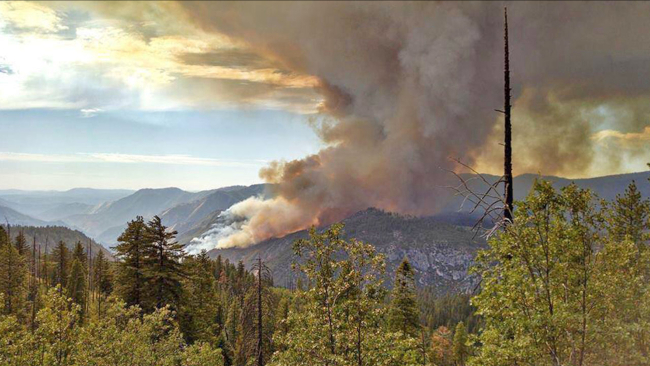

Wildfire modeling uses computational science to perform numerical simulations of fire events in order to understand and predict fire behavior. Wildfire modeling has many applications that encompass firefighter security, damage reduction, and protection of ecosystem services (Wikipedia, 2021).

In this tutorial, we will show you how to model wildfire events using the [r.ros](https://grass.osgeo.org/grass82/manuals/r.ros.html) and [r.spread](https://grass.osgeo.org/grass83/manuals/r.spread.html) modules of  [GRASS GIS](https://grass.osgeo.org/). We will perform fire simulations in the [Yosemite National Park](https://www.nps.gov/yose/index.htm) located in California USA (Figure 1) during the summer season in 2020 (`from 2020-06-20 through 2020-09-22`). This tutorial has three main sections: Getting Data, Importing Data, and Wildfire Simulation.

To follow along with this tutorial, please run this Jupyter Notebook in [Colaboratory Platform](https://colab.research.google.com/?hl=en) by clicking the **"Open in Colab"** button.

<a id='Getting Data'></a>
# 1. Getting Data

Getting the data we need to feed our models could be a daunting activity. Sometimes, data are not readily available because they are sparse or dispersed over a wide range of sources. In this section, we will show you an approach to readily gather data for wildfire modeling purposes. Table 1 shows the data used in this tutorial.

<center><strong>Table 1. Data used in this tutorial</strong></center>

| **Data**                              | **Source**                                                   | **Link**                                                     |
|:------------------------------------- |:------------------------------------------------------------ |:------------------------------------------------------------ |
| Yosemite National   Park polygon      | WDPA:  World Database on   Protected Areas (polygons)        | https://developers.google.com/earth-engine/datasets/catalog/WCMC_WDPA_current_polygons |
| 100-hour dead   fuel moisture         | GRIDMET: University of  Idaho Gridded Surface   Meteorological Dataset | https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET |
| Wind direction                        | GRIDMET: University of   Idaho Gridded Surface   Meteorological Dataset | https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET |
| Wind velocity                         | GRIDMET: University of   Idaho Gridded Surface   Meteorological Dataset | https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET |
| Enhanced Vegetation   Index (EVI)     | Google Earth Engine (GEE)                                    | https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_32DAY_EVI |
| Landsat 8 Surface   Reflectance       | USGS                                                         | https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T1_SR |
| High resolution   multispectral image | Planet Team (2017)                                           | https://api.planet.com                                       |
| Anderson Fire   Behavior Fuel Model   | LANDFIRE (LF) program                                        | https://landfire.cr.usgs.gov/fbfm13.php                      |


## 1.1 Loading Packages

This tutorial will be run in Colab, so you do not need to install packages or software on your local computer. All required packages and software will be installed into a free Google Cloud allocation.  

First of all, let's install some Python packages needed for this tutorial.

In [3]:
# install geopandas
!pip install geopandas --quiet

In [4]:
# install gdown
!pip install -U --no-cache-dir gdown --pre --quiet

Now, let's load all Python packages needed for this tutorial.

In [2]:
# GDF (GeoDataFrame) manipulation
import geopandas as gpd

# GEE data
import geemap
import ee

# path libraries
import os
import sys
import subprocess
import os.path
from os import path

# import zipping module
from zipfile import ZipFile

# display images
from IPython.display import Image
from subprocess import PIPE
from PIL import Image as Img

# IPython packages to visualize HTML
from IPython.core.display import display, HTML, Image, display_html

# avoid warning messages
import warnings
warnings.filterwarnings('ignore')


## 1.2 Downloading Data from GEE

We will use GEE Python API to download data from GEE cloud services and save the requested data in our local disk. First of all, we will initialize authenticate and initialize GEE.

**The Gmail account for Google Drive and Google Earth Engine should be the same**

In [ ]:
# trigger the authentication flow
ee.Authenticate()

To initialize the GEE library you should create a Google Cloud project, follow these instructions: https://developers.google.com/workspace/guides/create-project, and use the same Gmail account used to authenticate GEE. For example, create a project named "gge-wfs". Once the project has been created, search for Google Earth Engine resources and register your project. Return to the Google Cloud Dashboard, select your newly created project, copy the project ID, and paste it into the code below.

In [ ]:
# initialize the library.
ee.Initialize(project='your project ID')

Let's connect with our Gooogle Drive, and then create subfoders to store our data,

In [14]:
# mount Google Drive
from google.colab import drive # import drive from google colab

# deaful folder Google Drive
ROOT = "/content/drive"

drive.mount(ROOT) # we mount Drive at /content/drive

Mounted at /content/drive


In [16]:
# create working directory
!mkdir "drive/MyDrive/WFS_updated"

In [17]:
# change to working directory
%cd "drive/MyDrive/WFS_updated"

/content/drive/MyDrive/WFS_updated


In [ ]:
# create gisdata directory where we will store our data
!mkdir "gisdata"

In [ ]:
# create shp directory where we will store our shapefile data
!mkdir "gisdata/shp"

Next, we call the WDPA FeatureCollection (FC) and extract the Yosemite National Park polygon. We will save the extracted FC as a shapefile into our working directory.

In [ ]:
# get World Data Protected Areas (WDPA) FeatureCollection
pa = ee.FeatureCollection("WCMC/WDPA/current/polygons")

# Yosemite National Park polygon
filter = ee.Filter.inList('ORIG_NAME', ['Yosemite'])
yosemite = pa.filter(filter)

# define a function to filter polygons
def is_polygon(feature):
    # Return true if the feature's geometry type is 'Polygon' or 'MultiPolygon'
    geometry_type = feature.geometry().type()
    return ee.Algorithms.If(
        ee.Algorithms.IsEqual(geometry_type, 'Polygon'),
        True,
        ee.Algorithms.IsEqual(geometry_type, 'MultiPolygon')
    )

# apply the map method with a filter function to get only polygons
yosemite = yosemite.map(lambda feature: ee.Feature(feature).set('isPolygon', is_polygon(feature)))\
                .filter(ee.Filter.eq('isPolygon', True))

# save Yosemite fc into shp
geemap.ee_to_shp(yosemite, filename="gisdata/shp/yosemite.shp")

The following line of code allows us to set up an interactive map with Google Earth Engine (GEE) using [geemap](https://geemap.org/) package. We calculate the centroid of the protected area boundaries and get its coordinates. We then pass these coordinates to a geemap object, add the Yosemite layer and configure map controls.

In [ ]:
# get centroid coordinates of Yosemite polygon
yosemite_center = yosemite.geometry().centroid().getInfo()['coordinates']
yosemite_center.reverse()

# center lat and lot
lat = float(yosemite_center[0])
lon = float(yosemite_center[1])

# pass parameters
Map = geemap.Map(center=(lat, lon), zoom=9)
Map.addLayer(yosemite, {}, 'Yosemite National Park', True, 0.5)

# add map controls
Map.addLayerControl()

In [ ]:
Map

Map(center=[37.848243641443695, -119.55704246521199], controls=(WidgetControl(options=['position', 'transparen…

<center><strong>Figure 1. Yosemite National Park</strong></center>

According to Northern Rockies Coordination Center(n.d.): "100-Hour Fuel Moisture (100-hr FM) represents the modeled moisture content of dead fuels in the 1 to 3 inch diameter class. It can also be used as a very rough estimate of the average moisture content of the forest floor from three-fourths inch to four inches below the surface."

To obtain 100-Hour Fuel Moisture data from GEE we need first to call the GRIDMET ImageCollection and filter by date. Second, we create a rectangle that will be used to clip the data. Next, we select 100-hour dead fuel moisture (`fm100`) and calculate the mode. We then clip the resulting Image to the previously created polygon. After that, we create 2000 random points that will be used to sample the Image using the mean. Finally, we save the resulting FC
 as a shapefile into our working directory.

In [ ]:
# load GRIDMET ImageCollection
gridmet = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET') \
    .filter(ee.Filter.date('2020-06-20', '2020-09-22'));

# create a rectangle
coords = [-120.10157709250639,37.36645735913506,-118.99122199244081,38.31280791348237]
bbox = ee.Geometry.Rectangle(coords)

# select 100-hour dead fuel moisture (fm100) and calculate the mode
fm100 = gridmet.select('fm100').mode()

# clip data to rectangle
fm100_clip =fm100.clip(bbox)

# create 2000 random points
fm100_points = ee.FeatureCollection.randomPoints(bbox, 2000);

# sample points using the mean
samplefm100 = fm100_clip.reduceRegions(**{
  'collection':fm100_points,
  'reducer':ee.Reducer.mean(),
  'scale': 4000,
  });

# download FeatureCollection as shp
out_dir = 'gisdata/shp/'
out_shp = os.path.join(out_dir, "samplefm100.shp")
geemap.ee_export_vector(samplefm100, out_shp, verbose=True)

To obtain Wind Direction data from GEE we need first to select the GRIDMET Wind direction (`th`) band  and calculate the mode. Second, we clip the resulting Image to the previously created polygon. After that, we create 2000 random points that will be used to sample the Image using the mean.  Finally, we save the resulting FC as a shapefile into our working directory.

In [ ]:
# select wind direction and calculate the mode
th = gridmet.select('th').mean()

# clip data to rectangle
th_clip =th.clip(bbox)

# create 2000 random points
th_points = ee.FeatureCollection.randomPoints(bbox, 2000);

# sample points using the mean
sampleth = th_clip.reduceRegions(**{
  'collection':th_points,
  'reducer':ee.Reducer.mean(),
  'scale': 4000,
});

# download FeatureCollection as shp
out_shp = os.path.join(out_dir, "sampleth.shp")
geemap.ee_export_vector(sampleth, out_shp, verbose=True)

Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/WFS_updated/gisdata/shp/sampleth.shp


To obtain Wind Velocity data from GEE we need first to select the GRIDMET wind velocity (`vs`) band  and calculate the mode. Second, we clip the resulting Image to the previously created polygon. Next, we create 2000 random points that will be used to sample the Image using the mean. After that, we transform the resulting FC into a GeoDataFrame and create a new column where we store values in Foot per Minute. We save the resulting FC as a shapefile into our working directory. Finally, we open shapefile to transform values from meter per second to foot per minute.

In [ ]:
# select wind velocity and calculate the mode
vs = gridmet.select('vs').mean()

# clip data to rectangle
vs_clip =vs.clip(bbox)

# create 2000 random points
vs_points = ee.FeatureCollection.randomPoints(bbox, 2000);

# sample points using the mean
samplevs = vs_clip.reduceRegions(**{
  'collection':vs_points,
  'reducer':ee.Reducer.mean(),
  'scale': 4000,
});

# download FeatureCollection as shp
out_shp = os.path.join(out_dir, "samplevs.shp")
geemap.ee_export_vector(samplevs, out_shp, verbose=True)

Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/WFS_updated/gisdata/shp/samplevs.shp


In [ ]:
# open shapefile to transform values from meter per second to foot per minute
gdf = gpd.read_file("gisdata/shp/samplevs.shp")
gdf['vsfpm'] = gdf['mean']*197
gdf.to_file("gisdata/shp/samplevs.shp")

To get EVI data from GEE we need first to call the Landsat 8 Collection 1 Tier 1 32-Day EVI Composite, filter by date and bounds using Yosemite FC. Then, we calculate a mean Image and clip it using the previously created polygon. Finally, we export the clipped Image to our Google Drive storage using the [GEE Code Editor](https://code.earthengine.google.com/) and from there we move it to our working directory. **Open your [GEE Code Editor](https://code.earthengine.google.com/) to check the progress**.



In [ ]:
# load Landsat 8 Collection 1 Tier 1 32-Day EVI Composite
evi = ee.ImageCollection('LANDSAT/LC08/C01/T1_32DAY_EVI') \
            .filterDate('2020-06-20', '2020-09-22') \
            .filterBounds(yosemite)

# get mean image
evi_mean = evi.select('EVI').mean()

# clip data to rectangle
evi_clip = evi_mean.clip(bbox)

# export image to google drive
# open your GEE code editor, task tab to check the downloading state
geemap.ee_export_image_to_drive(evi_clip, description='evi', folder="WFS_updated", region=bbox, scale=30)

Now, let's create a *raster* folder where we will store our raster data, and move our raster data to this directory.

In [ ]:
# create raster directory where we will store our raster data
!mkdir "gisdata/raster"

In [ ]:
# let's move our raster data
!mv "evi.tif" "gisdata/raster"

In this tutorial, we use Landsat 8 images only for visualization purposes. To get Landsat 8 data from GEE we need first to call the USGS Landsat 8 Surface Reflectance Tier 1 collection, filter by date, cloudiness, and bounds using the Yosemite FC. Then, we calculate a median Image and clip it using the previously created polygon. Finally, we export the clipped Image to our Google Drive storage using the [GEE Code Editor](https://code.earthengine.google.com/) and from there we move it to our working directory. **Open your [GEE Code Editor](https://code.earthengine.google.com/) to check the progress**.

In [ ]:
# load landsat 8 sr image collection
l8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")

# filter image collection by bounds, date and cloud cover
l8_filter = l8.filterDate('2020-06-20', '2020-09-22').filterMetadata("CLOUD_COVER", "less_than", 10).filterBounds(yosemite)

# get median image
image = l8_filter.median()

# clip data to rectangle
image = image.clip(bbox)

# export image to google drive
# open your GEE code editor, task tab to check the downloading state
geemap.ee_export_image_to_drive(image, description='landsat', folder="WFS_updated", region=bbox, scale=30)

In [ ]:
# let's move our raster data
!mv "landsat.tif" "gisdata/raster"

To obtain DEM data using GEE, we must first call the NASA SRTM Digital Elevation 30m image. Then, select the elevation attribute and crop it using the bbbox. Finally, we export the cropped image to our Google Drive storage and from there we move it to our working directory. **Open your [GEE Code Editor](https://code.earthengine.google.com/) to check the progress**.

In [ ]:
# load NASA SRTM Digital Elevation 30m
srtm = ee.Image('USGS/SRTMGL1_003')

# select elevation attribute
dem = srtm.select('elevation')

# clip image to bbox
dem_clip = dem.clip(bbox)

In [ ]:
# exportar clipped DEM to google drive
geemap.ee_export_image_to_drive(dem_clip, description='dem', folder='WFS_updated', region=bbox, scale=30)

In [ ]:
# let's move our raster data
!mv "dem.tif" "gisdata/raster"

## 1.2 Downloading  Fire Behavior Fuel Model

To run our fire simulation we need a fuel model defined by the USDA Forest Service. In this case, we use the 13 Anderson Fire Behavior Fuel Model available at https://landfire.cr.usgs.gov/fbfm13.php . This model has 13 classes of fuel which vary in load, distribution, and particle size (Petrasova, et.al., 2018) (Table 2).

| Fuel class            | Description                    |
| :-------------------  | :----------------------------- |
| Grass and grass-dominated                              |
| 1                     | Short grass (1 foot)           |
| 2                     | Timber (grass and understory)  |
| 3                     | Tall grass (2.5 feet)          |
| Chaparral and shrub fields                             |
| 4                     | Chaparral (6 feet)             |
| 5                     | Brush (2 feet)                 |
| 6                     | Dormant brush, hardwood slash  |
| 7                     | Southern rough                 |
| Timber litter                                          |
| 8                     | Closed timber litter           |
| 9                     | Hardwood litter                |
| 10                    | Timber (litter and understory) |
| Slash                                                  |                                                                 
| 11                    | Light logging slash            |
| 12                    | Medium logging slash           |
| 13                    | Heavy logging slash            |

<strong>Table 2. Anderson Fuel Model Classes</strong>
<br>
<br>
To visualize our Fire Behavior Fuel Model we need to go to [LANDFIRE Viewer](https://www.landfire.gov/viewer/),  select `LF 2016 Remap (LF 200)/Fuel 2020 Capable/Suface and Canopy/US states us_200 13 Fire Behavior Fuel Models-Anderson (2020)` as you can see in Figure 2.

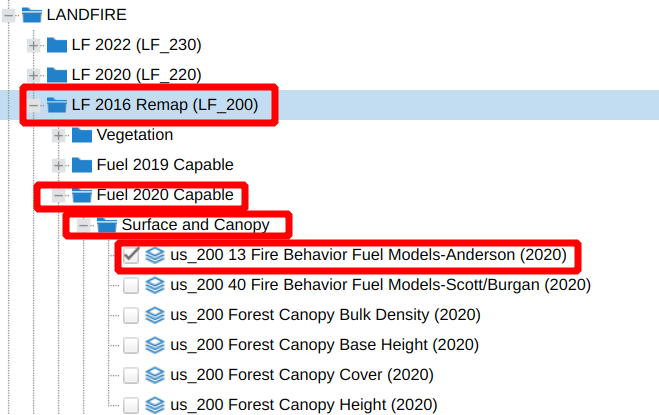

<strong>Figure 2. LANDFIRE Viewer </strong>

Now, to download the fire fuel model, go to the `Download Data Tool` and  select `Rectangle` method, then draw a rectangle near the Yosemite National Park and select the same dataset shown in Figure 2. At the botton of this window, refine the rectangle boundaries by entering the coordinates shown in Figure 3.

After entering the coordinates, press `Re-retrieve Products` and again  select the same dataset shown in Figure 2. Then, enter an email where you will get a data download link. Finally, clic the download button.

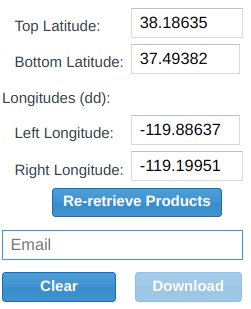

**Figure 3.LANDFIRE Viewer download tool**

For the sake of this tutorial, we will provide you with this dataset, so execute the following cells to download, unzip, and move the fuel model dataset to the corresponding folder.

In [ ]:
!gdown '1UUxOUUYywOcawluVLGCYWIbqCPW9_tS_'

Downloading...
From: https://drive.google.com/uc?id=1UUxOUUYywOcawluVLGCYWIbqCPW9_tS_
To: /content/drive/MyDrive/WFS_updated/files.zip
100% 1.58M/1.58M [00:00<00:00, 9.58MB/s]


In [ ]:
with ZipFile('files.zip', 'r') as f:
  #extract in current directory
  f.extractall()
  f.close()

os.remove('files.zip')

Let's move all raster files (fuel model and a planet image) contained inside the zipped file to our working directory.

In [ ]:
# move all raster files
!mv "files/raster/"* "gisdata/raster"

<a id='Importing Data'></a>

# 2. Importing Data

Now, we will proceed to import the data we download from GEE and other sources. This section involves setting up our GRASS GIS environment and loading the data itself.


## 2.1 Setting up GRASS GIS

When setting up GRASS in Jupyter Notebook we use Python to initialize GRASS GIS. First, we instal GRASS GIS and then create a GRASS GIS runtime environment by passing in a variable the directory where GRASS GIS "lives" and tie it to the Python directory. Next, we import GRASS GIS packages. After that, we set up default font displays and the overwrite behavior so that we do not need to add the `--overwrite` flag every time we execute a command.

In [ ]:
# install GRASS GIS
%%bash
DEBIAN_FRONTEND=noninteractive
sudo add-apt-repository ppa:ubuntugis/ubuntugis-unstable
apt update
apt install grass subversion grass-dev
apt remove libproj22

In [6]:
# check if GRASS GIS is installed
!grass --config path

/usr/lib/grass83


In [7]:
# ask GRASS GIS where its Python packages are to be able to run it from the notebook
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

In [8]:
# import the GRASS GIS packages we need
import grass.script as gs
import grass.jupyter as gj

In [9]:
# default font displays
os.environ['GRASS_FONT'] = 'sans'
# overwrite existing maps
os.environ['GRASS_OVERWRITE'] = '1'
gs.set_raise_on_error(True)
gs.set_capture_stderr(True);

## 2.2 Create GRASS GIS Location and login

In GRASS GIS, projects are organized by areas stored in subdirectories called Locations. Each Location is defined by its coordinate system, projection and geographical limits. To create a Location we will use the command [`grass`](https://grass.osgeo.org/grass84/manuals/grass.html) with flags *-e* (
Exit after creation of location or mapset), *-c EPSG:3310* to create new GRASS projected location in specified GISDBASE with given EPSG code (3310) ([NAD83 / California Albers](https://epsg.io/3310)).We indicate to GRASS GIS that the initial database directory is *grassdata* and the location name is *wfs_3310*, then we create a new *Mapset* called `yosemite` and check if we are working into this Mapset

In [ ]:
!grass -e -c EPSG:3310 grassdata/wfs_3310

Starting GRASS GIS...
Creating new GRASS GIS location <wfs_3310>...
Cleaning up temporary files...
Cleaning up temporary files...


In [30]:
# data directory
homedir = "/content/drive/MyDrive/WFS_updated"

# GRASS GIS database variables
grassdata = os.path.join(homedir, "grassdata")
location = "wfs_3310"
mapset = "PERMANENT" #"yosemite"

In [31]:
# Start the GRASS GIS Session
session = gj.init(grassdata, location, mapset)

In [32]:
# Create a new mapset
gs.run_command("g.mapset",
               mapset="yosemite",
               flags="c")

In [33]:
# show current GRASS GIS settings to check if we are in the created Location and Mapset
gs.gisenv()

{'GISDBASE': '/content/drive/MyDrive/WFS_updated/grassdata',
 'LOCATION_NAME': 'wfs_3310',
 'MAPSET': 'yosemite'}

## 2.2 Loading Data

In this subsection, we will upload all the datasets we need to run our fire simulation.  Let's import our fuel model raster.

In [ ]:
# import fuel model raster
# your path could differ, so set you path accordingly
gs.run_command('r.import', input='gisdata/raster/LC20_F13_200.tif',output='fuel', \
    resolution='value', resolution_value=30.0);

Next, we set the Region to `fuel` raster and print its information. We also need to import some pygrass packages to set the Region.

In [ ]:
from grass.pygrass.modules.shortcuts import raster as r, vector as v, general as g, display as d

In [ ]:
# set region
g.region(raster='fuel')

# print region info
print(g.region(flags='p', stdout_=PIPE).outputs.stdout)

projection: 99 (NAD83 / California Albers)
zone:       0
datum:      nad83
ellipsoid:  grs80
north:      33210
south:      -72240
west:       -8880
east:       88950
nsres:      30
ewres:      30
rows:       3515
cols:       3261
cells:      11462415



Once we set the region, we will proceed to import other required datasets.

In [ ]:
# import Yosemite National Park vector
gs.run_command('v.import', input='gisdata/shp/yosemite.shp',output='yosemite')

# import evi raster
gs.run_command('r.import', input='gisdata/raster/evi.tif', output='evi', \
    resolution='value', resolution_value=30.0)

# import fm 100h samples
gs.run_command('v.import', input='gisdata/shp/samplefm100.shp', \
                   output='samplefm100')

# import vs (wind velocity) samples
gs.run_command('v.import', input='gisdata/shp/samplevs.shp', \
                   output='samplevs')

# import th (wind direction) samples
gs.run_command('v.import', input='gisdata/shp/sampleth.shp', \
                   output='sampleth')

# import landsat image
gs.run_command('r.import', input='gisdata/raster/landsat.tif',output='landsat', \
                   resolution='value', resolution_value=30.0)

# import dem
gs.run_command('r.import', input='gisdata/raster/dem.tif',output='dem',\
               resolution='value',resolution_value=30.0);

The following datasets will be used to define our study area. They are stored in the previously unzipped file, so run the next cell to move them to our working directory.

In [ ]:
# move all raster files
!mv "files/study_area/"* "gisdata/shp"

In [ ]:
# import study area shapefile
gs.run_command('v.import', input='gisdata/shp/sa.shp',output='sa');

<a id='Wildfire Simulation'></a>

# 3. Wildfire Simulation

We will simulate wildfire spread in in the Yosemite National Park (Figure 4). We will derive new data from the imported data, model fire events with different durations, and visualize wildfire propagation.

## 3.1 Creating a Map of the Study Area

To visualize the park polygon and the study area we will use the [grass.jupyter package](https://grass.osgeo.org/grass83/manuals/libpython/grass.jupyter.html). Through the `InteractiveMap()` function we will create an interactive GRASS map. We first create an interactive map, set vector styles, add vectors of the park and the study area, and add the map title.

In [ ]:
# create interactive map
fig = gj.InteractiveMap(width=600, height=600, tiles='OpenStreetMap', use_region=True)

In [ ]:
# set vector styles
def yose_style(vector):
  return {
      "fillOpacity": 0.0,
      "weight": 3,
      'color': "#000"
      }
def sa_style(vector):
  return {
      "fillOpacity": 0.0,
      "weight": 2,
      'color': "#FF0000"
      }

# add vectors and map control
fig.add_vector("yosemite", title='Yosemite Boundary', style_function=yose_style)
fig.add_vector("sa", title="Study Area",  style_function=sa_style)
fig.add_layer_control(position = "bottomright")

# add map title
display(HTML('<h1 style="font-size:150%";>\
<strong>Study Area</strong></h1>'))

# show map
fig.show()

**Figure 4. Study Area**

## 3.2 Wildfire Simulation

The study area is located in the center-east  of the Yosemite National Park  (Figure 5). Mean slope is 14.49 degree, mean wind speed is  467.37 foot/min, mean dead fuel moisture 1 hour is 2.87% and area is: 270.26 $km^2$. Predominant fuel classes are Closed timber litter with a coverage of 29.70%, and Timber (grass and understory) covering 21.67% of the study area (to learn more about fuel classes click [here](https://iftdss.firenet.gov/firenetHelp/help/pageHelp/content/10-mapstudio/files/fbfmsummaries.htm)). According to the NLCD: USGS National Land Cover Database (Yang et.al.,2018), this area is mainly covered by evergreen forest (51%), shrub/scrub (34%), and grassland/herbaceous(5%) (Figure 6).

The goal of the fire simulation in this Region is to determine how wildfire simulation behaves in a large area surrounded by mountains (valley), and during a long time (32 hours).

We'll begin by setting our Region to Study Area.

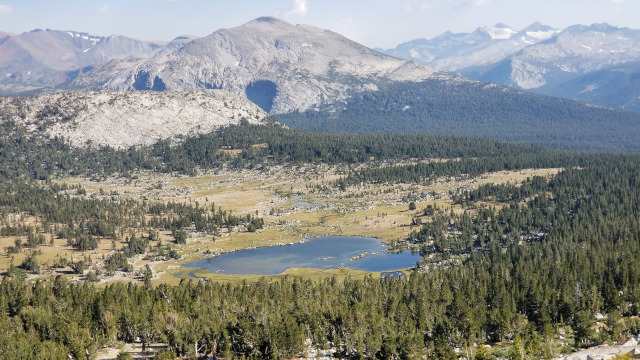

**Figure 5. Overview of the Study Area**

In [ ]:
# set region and save it
g.region(vector='sa')
g.region(save='sa');

### 3.2.1 Calculating Data

Modeling wildfire events is a two-step process. First, we execute the `r.ros` module that generates Rate of Spread (ROS) raster maps. Second, we run the `r.spread` module that simulates elliptically anisotropic spread.

As we assume windy and topographically sharp conditions, r.ros module needs the following map inputs:

- model: raster map containing fuel model.
- moisture_1h: raster map containing the 1-hour fuel moisture (%).
- moisture_live: raster map containing live fuel moisture (%).
- velocity: raster map containing wind velocities (ft/min).
- direction: raster map containing wind directions (degree).
- slope: raster map containing slope (degree).
- aspect: raster map containing aspect, counterclockwise from east (GRASS convention) in degrees.
- elevation: raster map containing elevation (m).

We'll use the `v.surf.idw` module to derive the `moisture_100h` raster map from vector point (`samplefm100`)  by Inverse Distance Squared Weighting. To calculate `moisture_1h` raster we'll use the following expression:


$$moisture{\_}100h = moisture{\_}10h + 1 = moisture{\_}1h + 2 \ (GRASS \ Development \ Team,\ 2021)$$


`r.mapcal` module will be run to calculate `moisture_10h` from `moisture_100h` and `moisture_1h` from `moisture_10h`.

We enter the follwing expression in the `r.mapcal` module to calculate `moisture_live`:

$$LFM = (417.602 × EVI) + 6.7806\ (Myoung, et.al.,2018)$$

Where `LFM` is Live Fuel Moisture and `EVI` is Enhanced Vegetation Index. The resulting raster will be rescaled to 0-100 as we need percentage content multiplied by 100.

We'll the use v.surf.idw module to derive the `velocity` raster map from vector point (samplevs) by Inverse Distance Squared Weighting.

We'll the use v.surf.idw module to derive the `direction` raster map from vector point (sampleth) by Inverse Distance Squared Weighting.

`slope` and `aspect` raster maps will be calculated through the `r.slope.aspect` module.

As these raster maps will be calculated for each Study Area, we will write a function to carry out these tasks.

In [ ]:
def caldata(regname, suffix):

    '''Function to calculate GRASS GIS raster for slope, aspect, fuel moisture 100h, fuel moisture 10h,
    fuel moisture 1h, wind velocity, wind direction, and live fuel moisture

    :param:str regname:region name
    :param:str suffix:GRASS raster filename suffix

    :return str: successfulness message
    '''
    try:
        # set region
        g.region(region=regname)

        # calculate slope and aspect
        gs.run_command('r.slope.aspect', elevation='dem', slope='slope'+suffix, aspect='aspect'+suffix)

        # calculate fuel moisture 100h raster from point data
        gs.run_command('v.surf.idw', input='samplefm100', output='moisture_100h'+suffix, \
                       column='mean')

        # calculate wind velocity raster from point data
        gs.run_command('v.surf.idw', input='samplevs', output='wind_speed'+suffix, \
                       column='vsfpm')

        # calculate wind direction raster from point data
        gs.run_command('v.surf.idw', input='sampleth', output='wind_dir'+suffix, \
                           column='mean')

        # define variable for string concatanation
        ss1 = 'moisture_1h'
        ss10 = 'moisture_10h'
        ss100 = 'moisture_100h'
        lfm='lfm'

        # moisture_100h = moisture_10h + 1 = moisture_1h + 2
        # moisture_10h = moisture_100h -1
        expm10 = ss10+suffix+'='+ss100+suffix+'-1'
        r.mapcalc(expression=expm10)

        # moisture_100h = moisture_10h + 1 = moisture_1h + 2
        # moisture_1h =  moisture_10h -2
        expm1 = ss1+suffix+'='+ss10+suffix+'-2'
        r.mapcalc(expression=expm1)

        # estimating live fuel moisture from evi
        explfm = lfm+suffix+'=(417.602 * evi) + 6.78061'
        r.mapcalc(expression=explfm)

        # rescale LFM to 0-100
        output = lfm+suffix+'_scaled'
        r.rescale(input='lfm'+suffix, output=output, to=(0,100));

        return "successfully calculated"

    except:
        print("Something went wrong")

In [ ]:
caldata('sa', '_sa')

'successfully calculated'

### 3.2.2  Modeling

As we mentioned, modeling wildfires is a two-step process, we execute the `r.ros` module and then the `r.spread` module. According to GRASS Development Team (2021) `r.ros` "generates three, or four raster map layers showing the base (perpendicular) rate of spread (ROS), the maximum (forward) ROS, the direction of the maximum ROS, and optionally the maximum potential [spotting distance](https://www.nwcg.gov/publications/pms437/crown-fire/spotting-fire-behavior#TOC-Estimating-Maximum-Spotting-Distance) for fire spread simulation".



The following `r.ros` outputs are the inputs of the `r.spread` module:

- base_ros: raster map containing base ROS (cm/min).
- max_ros: raster map containing maximal ROS (cm/min).
- direction_ros: raster map containing directions of maximal ROS (degree).
- spotting_distance: raster map containing maximal spotting distance (m).

Let's enter our data and run the `r.ros` module.

In [ ]:
# generates rate of spread raster map
r.ros(model='fuel', moisture_1h='moisture_1h_sa', \
    moisture_live='lfm_sa_scaled', velocity='wind_speed_sa', \
    direction='wind_dir_sa', slope='slope_sa', aspect='aspect_sa', \
    elevation='dem', base_ros='out_base_ros', \
    max_ros='out_max_ros', direction_ros='out_dir_ros', \
    spotting_distance='out_spotting');

Now, let's move to our working directory an `.txt` file containg ASCII points to create vector map with the following coordinates: `56978.3098189104,-12406.60548812005
`.

In [ ]:
# create working directory for .txt
!mkdir "gisdata/txt"

In [ ]:
# let's move all .txt files to our working directory
!mv "files/txt/"* "gisdata/txt"

Once the vector map has been created, we'll rasterize it. This raster map will be the source of our fire simulation.

In [ ]:
# create a vector map from an ASCII points
gs.run_command('v.in.ascii',input='gisdata/txt/source.txt', \
                   output='source', separator='comma');

# rasterize vector map
gs.run_command('v.to.rast', input='source', output='source', type='point', use='cat');

As soon as we define our source, we can execute the `r.spread` module. According to GRASS Development Team (2021) `r.spread` "generates a raster map of the cumulative time of spread, given raster maps containing the rates of spread (ROS), the ROS directions, and the spread origins". It is important to note that spread phenomena show variable behavior over the space due to dissimilar conditions from place to place (spatial heterogeneity), and variable conditions in different directions (anisotropy). The simplest shaoe of a uneven spatial and anisotropic spread is an elliptical spread where each spread can be regarded as an ellipse (GRASS Development Team, 2021).

Let's run the `r.spread` module. Our start is the above-rasterized point. Our simulation period is 480 min (8 hours) because the initial time for the current simulation is `0` (default value) and our lag is `480` min. Note that we use the `"s"` flag because we are considering spotting distance.

In [ ]:
# elliptically anisotropic spread simulation 8 hours
r.spread(flags="s", base_ros='out_dir_ros', max_ros='out_max_ros', \
    direction_ros='out_dir_ros', start='source', \
    spotting_distance='out_spotting', wind_speed='wind_speed_sa', \
    fuel_moisture='moisture_1h_sa', output='spread_8h', lag=480);

For visualization purposes, we set null values to `0` and create a color table with the following rules:

$$0{\%}\ 50:50:50$$
$$60{\%}\ yellow$$
$$100{\%}\ red$$

In [ ]:
# set null values
r.null(map='spread_8h', setnull=0);
# create color table
r.colors(map='spread_8h', rules='gisdata/txt/fire_colors.txt');

Let's run again the `r.spread` module. Our simulation period is `960` min (16 hours) because the initial time for the current simulation is `480` min and our lag is `480` min. Note that we use the `"si"` flags because we are considering spotting distance and our start is the output of the previous execution.

In [ ]:
# elliptically anisotropic spread simulation 16 hours
gs.run_command('r.spread', flags='si', base_ros='out_dir_ros', max_ros='out_max_ros', \
                   direction_ros='out_dir_ros', start='spread_8h', \
                   spotting_distance='out_spotting', wind_speed='wind_speed_sa', \
                   fuel_moisture='moisture_1h_sa', output='spread_16h', lag=480, init_time=480);

In [ ]:
# set null values
r.null(map='spread_16h', setnull=0);
# create color table
r.colors(map='spread_16h', rules='gisdata/txt/fire_colors.txt');

Let's run again the `r.spread` module. Our simulation period is `1140` min (24 hours) because the initial time for the current simulation is `960` min  and our lag is `480` min. Note that we use the "si" flags because we are considering spotting distance and our start is the output of the previous execution.

In [ ]:
# elliptically anisotropic spread simulation 24 hours
gs.run_command('r.spread', flags='si', base_ros='out_dir_ros', max_ros='out_max_ros', \
                   direction_ros='out_dir_ros', start='spread_16h', \
                   spotting_distance='out_spotting', wind_speed='wind_speed_sa', \
                   fuel_moisture='moisture_1h_sa', output='spread_24h', lag=480, init_time=960);

In [ ]:
# set null values
r.null(map='spread_24h', setnull=0);
# create color table
r.colors(map='spread_24h', rules='gisdata/txt/fire_colors.txt');

Let's run again the `r.spread` module. Our simulation period is `1932` min (32 hours) because the initial time for the current simulation is `1140` min  and our lag is `480` min. Note that we use the "si" flags because we are considering spotting distance and our start is the output of the previous execution.

In [ ]:
# elliptically anisotropic spread simulation 32 hours
gs.run_command('r.spread', flags='si', base_ros='out_dir_ros', max_ros='out_max_ros', \
                   direction_ros='out_dir_ros', start='spread_24h', \
                   spotting_distance='out_spotting', wind_speed='wind_speed_sa', \
                   fuel_moisture='moisture_1h_sa', output='spread_32h', lag=480, init_time=1440);

In [ ]:
# set null values
r.null(map='spread_32h', setnull=0);
# create color table
r.colors(map='spread_32h', rules='gisdata/txt/fire_colors.txt');

### 3.2.3 Visualization

Having executed the r.ros and r.spread modules we can now visualize our results. Before setting up our visualization parameters we will create a function to reclassify fire spread raster based on percentiles. Through this function, we will generate a reclassified rater that will serve to set a raster legend bar showing fire rate of spread from 0 to 100 %.

In [22]:
def reclassRast(rastspread):

    '''Function to reclassify fire spread raster based on percentiles

    :param:str rastspread:raster name

    :return str: successfulness message

    '''
    try:

        # parse r.quantile command
        valclass = gs.parse_command('r.quantile', input=rastspread, percentiles=(0,15,60,100), delimiter=':')
        valclassdict = dict(valclass)

        # convert dictionary to list and extract values
        l = list(valclassdict.values())
        n1 = str(int(float(l[0].split(":")[1])))
        n2 = str(int(float(l[1].split(":")[1])))
        n3 = str(int(float(l[2].split(":")[1])))
        n4 = str(int(float(l[3].split(":")[1])))

        # define variable for string concatanation
        ss1 = 'gisdata/txt/'
        ss2 = '_reclass.txt'

        # create a text file rule for classification and write values
        filename = ss1+rastspread+ss2
        f= open(filename,"w+")
        f.write(n1 + " " + "thru" + " " + n2 + " " + "=" + " " + "15""\n")
        f.write(n2 + " " + "thru" + " " + n3 + " " + "=" + " " + "60""\n")
        f.write(n3 + " " + "thru" + " " + n4 + " " + "=" + " " + "100")
        f.close()

        # reclassify raster map based on category values
        r.reclass(input=rastspread, output=rastspread+'_reclass', \
              rules=filename);

        # change colors
        r.colors(map=rastspread+'_reclass', rules='gisdata/txt/fire_colors.txt')

        return "successfully calculated"

    except:
        print("Something went wrong")

In [23]:
# reclassify spread 32h to create a lengend bar depicting the rate of spread in percentage
reclassRast('spread_32h')

Something went wrong


ERROR: Raster map <spread_32h> not found


Now, we will perform an auto-balancing of colors for the Landsat 8 image. We'll also combine red, green, and blue raster maps into a single composite raster map to create a [Color Infrared (CIR)](https://www.mngeo.state.mn.us/chouse/airphoto/cir.html) composite.

In [ ]:
# enhance colors Landsat image
gs.run_command('i.colors.enhance',red='landsat.5',green='landsat.4', \
  blue='landsat.3', strength=95);

In [ ]:
#  combine red, green and blue raster maps into a single composite raster map
# to create a  standard "false color" composite (5, 4 3)
r.composite(red='landsat.5', green='landsat.4', blue='landsat.3', output='landsat_cir_sa');

Next, we will create an interactive map for each simulation period using the Jupyter GRASS module. For each period we are going to add the focus or start of the fire, the infrared false color composition, and the simulation with the cumulative time of spread .

##### **Interactive Map 8 hours**

In [34]:
# create interactive map
fig = gj.InteractiveMap(width=600, height=350, tiles='OpenStreetMap', use_region=True)

# add fire source
fig.add_vector("source", title="Fire source")

# add CIR image
fig.add_raster("landsat_cir_sa", opacity=0.8, title="Landsat CIR")

# ad raster cumulative time of spread 8 hours hours
fig.add_raster("spread_8h", opacity=1.0, title="Fire spread 8 hours")

# add layer control
fig.add_layer_control(position = "bottomright")

##### **Interactive Map 16 hours**

In [35]:
# create interactive map
fig_2 = gj.InteractiveMap(width=600, height=350, tiles='OpenStreetMap', use_region=True)

# add fire source
fig_2.add_vector("source", title="Fire source")

# add CIR image
fig_2.add_raster("landsat_cir_sa", opacity=0.8, title="Landsat CIR")

# add raster cumulative time of spread 16 hours
fig_2.add_raster("spread_16h", opacity=1.0, title="Fire spread 16 hours")

# add layer control
fig_2.add_layer_control(position = "bottomright")

##### **Interactive Map 24 hours**

In [36]:
# create interactive map
fig_3 = gj.InteractiveMap(width=600, height=350, tiles='OpenStreetMap', use_region=True)

# add fire source
fig_3.add_vector("source", title="Fire source")

# add CIR image
fig_3.add_raster("landsat_cir_sa", opacity=0.8, title="Landsat CIR")

# add raster cumulative time of spread 24 hours
fig_3.add_raster("spread_24h", opacity=1.0, title="Fire spread 24 hours")

# add layer control
fig_3.add_layer_control(position = "bottomright")

##### **Interactive Map 32 hours**

In [37]:
# create interactive map
fig_4 = gj.InteractiveMap(width=600, height=350, tiles='OpenStreetMap', use_region=True)

# add fire source
fig_4.add_vector("source", title="Fire source")

# add CIR image
fig_4.add_raster("landsat_cir_sa", opacity=0.8, title="Landsat CIR")

# ad raster cumulative time of spread 32 hours
fig_4.add_raster("spread_32h", opacity=1.0, title="Fire spread 32 hours")

# add layer control
fig_4.add_layer_control(position = "bottomright")

##### **Create legend**
Next, through the GRASS command [`d.mon`](https://grass.osgeo.org/grass83/manuals/d.mon.html) we create a virtual monitor that generates a file with *.png* extension that we can display inside the notebook with the function `Image` of the `display` module of `Ipython`.

Through the module [`d.vect`](https://grass.osgeo.org/grass83/manuals/d.vect.html) we show the vector map *source* inside the virtual monitor. However, since we are interested in the legend and not the vector itself, we use the `display='vert'` parameter so that this vector is not displayed on the virtual monitor. To generate the legend of the vector map we use the command [`d.legend.vect`](https://grass.osgeo.org/grass83/manuals/d.legend.vect.html).Finally, with the GRASS command ` d.legend` we generate the legend for the raster maps.

The parameters of the `d.vect` command are as follows:

* `map`: name of the vector map
* `size`: symbol size
* `icon`: point and centroid symbol
* `color`: color of the entity
* `fill_color`: fill color
* `legend_label`: label to display after the symbol
* `display`: in our case, show vertices of the entity

The parameters of the `d.legend.vect` command are as follows:

* `at`: position of the legend on the screen.
* `fontsize`: font size
* `bgcolor`: background color

In [ ]:
# create images folder into our working directory
!mkdir 'gisdata/images'

In [ ]:
# create virtual monitor
gs.run_command('d.mon',start='cairo', output='gisdata/images/fs_leg.png', width=1200, height=75)

# crete legend for vector maps
gs.run_command('d.vect', map='source_3', size=35, icon='basic/pin_dot', color=(43,130,203), \
               fill_color=(43,130,203), legend_label='Foco', display='vert')
gs.run_command('d.legend.vect', at=(20,70), fontsize=13, bgcolor='white')

# crear legend for raster map
gs.run_command('d.legend', flags='s', raster='spread_32h_reclass', \
                   at=(35,55, 35, 65), title='Fire Spread (%)', title_fontsize= 13, fontsize=10)

# release monitor
gs.run_command('d.mon', flags='r');

##### **Visualize interactive maps of fire spread 8 and 16 hours**

To display the interactive maps in the Notebook, we use the IPython HTML() function. To create map titles. Then with Ipython's repr_html() function we concatenate two interactive maps to display them in the same file. Finally with the Image() function we visualize the legend.

In [40]:
# create and show map titles
display(HTML('<h1 style="font-size:150%;position:absolute;top:2px;left:150px;text-shadow:2px 2px 5px white;">\
  <strong>Fire Spread 8 Hours</strong></h1>' '<h1 style="font-size:150%;position:absolute;\
  top:2px;left:750px;text-shadow:2px 2px 5px white;"><strong>Fire Spread 16 Hours</strong></h1>'))

# concatenate and show interactive maps
display_html(fig.show()._repr_html_()+" "+fig_2.show()._repr_html_(), raw=True)

# show legend
Image('gisdata/images/fs_leg.png')

##### **Visualize interactive maps of fire spread 24 and 32 hours**

In [41]:
# create and show map titles
display(HTML('<h1 style="font-size:150%;position:absolute;top:2px;left:150px;text-shadow:2px 2px 5px white;">\
  <strong>Fire Spread 24 Hours</strong></h1>' '<h1 style="font-size:150%;position:absolute;\
  top:2px;left:750px;text-shadow:2px 2px 5px white;"><strong>Fire Spread 32 Hours</strong></h1>'))

# concatenate and show interactive maps
display_html(fig_3.show()._repr_html_()+" "+fig_4.show()._repr_html_(), raw=True)

# show legend
Image('gisdata/images/fs_leg.png')

## ***Optionally remove your Working Directory***

In [ ]:
import shutil
shutil.rmtree("WFS_updated")

# 4. Discussion

This tutorial demonstrates we can integrate GRASS GIS, Google Earth Engine, and Jupyter Notebook in a unique development environment. However, more work should be done in order to pass GEE and Geopandas objects into GRASS GIS modules.

The results of the Fire simulation in our  Study Area  suggest that the modeling raster outputs do not overlap non-vegetated areas. In our case, fire simulations perform better in large areas because our base spatial resolution is 30m which is suitable for studies at a regional scale. Data should be generated to simulate wildfire at a finer scale.

In this tutorial, for the `v.surf.idw` module we used default parameters. It could be interesting to try out different interpolation parameters and evaluate how they affect simulation outputs.

Finally, we suggest assessing fire spread outputs after running the `r.ros` and `r.sread` modules with field measurements of dead fuel moisture, live fuel moisture, wind velocity, and wind direction.

# 5. References

GRASS Development Team(2021). GRASS GIS 7.8.6dev Reference Manual. Retrieved April 17, 2021, from https://grass.osgeo.org/grass78/manuals/.

Petrasova, A., Harmon, B., Petras, V., Tabrizian, P., & Mitasova, H. (2018). Wildfire spread simulation. In Tangible Modeling with Open Source GIS (pp. 155-163). Springer, Cham.

Myoung, B., Kim, S. H., Nghiem, S. V., Jia, S., Whitney, K., & Kafatos, M. C. (2018). Estimating live fuel moisture from MODIS satellite data for wildfire danger assessment in Southern California USA. Remote Sensing, 10(1), 87.

Northern Rockies Coordination Center(n.d). PSA NFDRS Component Glossary. Retrieved April 16, 2021, from  
https://gacc.nifc.gov/nrcc/predictive/fuels_fire-danger/psa_component_glossary.htm

Planet Team (2017). Planet Application Program Interface: In Space for Life on Earth. San Francisco, CA. https://api.planet.com.

Yang, L., Jin, S., Danielson, P., Homer, C., Gass, L., Case, A., Costello, C., Dewitz, J., Fry, J., Funk, M., Grannemann, B., Rigge, M. and G. Xian. 2018, A New Generation of the United States National Land Cover Database: Requirements, Research Priorities, Design, and Implementation Strategies, p. 108–123.

Wikipedia. 2021. "Wildfire modeling." Last modified January 10, 2021.https://en.wikipedia.org/wiki/Wildfire_modeling.